训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。批量规范化这是一种流行且有效的技术。

批量规范化层在”训练模式“（通过小批量统计数据规范化）和“预测模式”（通过整个数据集统计规范化）中的功能不同。 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。 而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。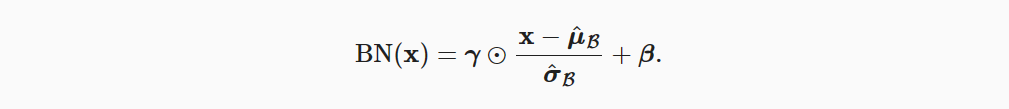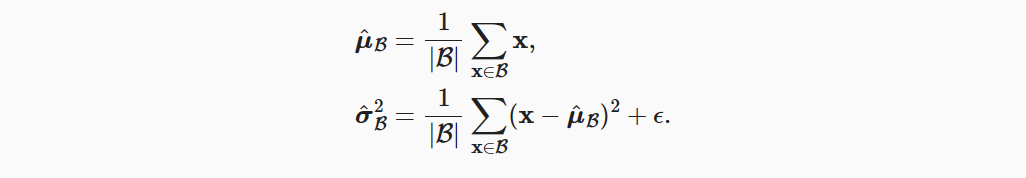

## BN在全连接层的实现
我们将批量规范化层置于全连接层中的仿射变换(线性组合)和激活函数之间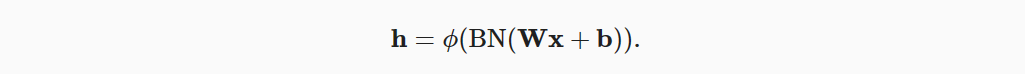

## BN在卷积层的实现
我们可以在卷积层之后和非线性激活函数之前应用批量规范化。当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。

## 从零实现BN

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# gamma和beta是要学习的参数
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的整个数据集的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)  # 全连接层的输入是二维，2d卷积层输入是四维
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算不同样本同一特征上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0) # 方差
        else:
            # 使用二维卷积层的情况，计算不同样本在通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新整个数据集的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    # num_features：全连接层的输出数或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 整个数据集各特征的平均值以及方差初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 调用上面实现的BN算法，保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 在LeNet中使用批量规范化

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

和以前一样，我们将在Fashion-MNIST数据集上训练网络。 这个代码与我们第一次训练LeNet时几乎完全相同，主要区别在于学习率大得多。

loss 0.270, train acc 0.901, test acc 0.882
23281.6 examples/sec on cuda:0


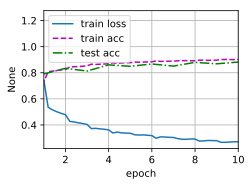

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.5499, 3.4657, 3.1242, 3.0129, 3.3848, 0.8477], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-1.9943, -0.2519, -3.3749,  2.1708, -1.9380,  1.0752], device='cuda:0',
        grad_fn=<ViewBackward>))

## 使用nn.BatchNorm2d简洁实现

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

下面，我们使用相同超参数来训练模型。 请注意，通常高级API变体运行速度快得多，因为它的代码已编译为C++或CUDA，而我们的自定义代码由Python实现。

loss 0.261, train acc 0.904, test acc 0.846
38041.8 examples/sec on cuda:0


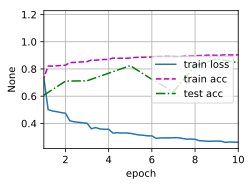

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())